<h1> Link Partitioning Around Medoids with Clarance Heuristic </h1>
<br/>
Distance function: Amplified Commute Distance

In [1]:
import numpy as np
import random
random.seed = 108
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
%matplotlib inline

In [2]:
!pwd

/home/latna/aponom/clustering/Scripts


In [154]:
!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar

Missing required options: i, k
usage: PMPClustering <-i input_file> <-k number_of_clusters> [-ftbcd]
 -a,--algorithm <arg>         Specifies algorithm that will be used to
                              find disjoint edge clusters. Possible
                              values:
                              pmp (p-median exact algorithm).
                              kmd (k-medoids heuristic)
                              kmn (k-means heuristic).
                              If this option is omitted, the P-Median
                              algorithm will be used.
 -b,--benchmark               use benchmark format
 -c,--communitiesFile <arg>   use communities file to validate benchmark
 -d,--distance <arg>          the type of function to measure the distance
                              between nodes.
                              Possible values:
                              sp (shortest path)
                              gd (Generalize Degree)
                              cm

In [167]:
def lp_experiment(clustersNumber, algorithm, distance, inputFile, groundTruth, params = {}, vertexNumerationShift=0, benchmarkFormat=False):
    datasetName = inputFile.split('/')[-2]
    sufix = inputFile.split('/')[-1].split('.')[0]
    outputDir = "../Results/lp_{}_{}_{}".format(algorithm, distance, datasetName)
    outputFile = outputDir +'/' +"pmp_{3}_{2}_{0}_{1}.dat".format(algorithm, clustersNumber, distance.upper(), sufix)
    print("Output dir name: {}".format(outputDir) )
    print("Output file name: {}".format(outputFile) )
    all_results = {}
    bestParam = "not found"
    nmi_best = 0;
    param_list = list(generate_params(params))
    for param in tqdm(param_list):
        if benchmarkFormat:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} {param}
            tmpFile = outputFile
        else:
            tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -k {clustersNumber} -d {distance} {param}
            lines=[]
            with open(outputFile) as f:
                lines = f.readlines()    
            tmpFile="tmpFile.dat"
            with open(tmpFile, 'w') as the_file:
                for line in lines:
                    the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

        output=!../Overlapping-NMI/onmi {groundTruth} {tmpFile}
        nmi=float(output[0].split()[1])
        all_results[param] = nmi
        if nmi >  nmi_best:
            bestParam = param
            nmi_best = nmi
    #restorign solution for the best parameters           
    if benchmarkFormat:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -b -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} {bestParam}
        tmpFile = outputFile
    else:
        tmp=!java -jar ../lpam/out/artifacts/Clustering_jar/Clustering.jar -a {algorithm} -o {outputDir} -i {inputFile} -gt {groundTruth} -k {clustersNumber} -d {distance} {bestParam}
        lines=[]
        with open(outputFile) as f:
            lines = f.readlines()    
        tmpFile="tmpFile.dat"
        with open(tmpFile, 'w') as the_file:
            for line in lines:
                the_file.write(" ".join([str(int(a)+vertexNumerationShift) for a in line.split()]) + "\n")

    print("Best ONMI: {} params: '{}'".format(nmi_best, bestParam) )
    return all_results

In [161]:
def generate_params(params):
    keys = list(params.keys())
    if len(keys) == 1:
        for value in params[keys[0]]:
            yield ( keys[0] + " " + str(value) )        
    if len( keys ) > 1:
        for value in params[keys[0]]:
            for remain_params in generate_params({k:params[k] for k in keys[1:]}):
                yield ( keys[0] + " " + str(value) + " " + remain_params )

In [162]:
def plot_all_params(algorithm, dataset, all_results ):
    xdata=[]
    ydata=[]
    df = pd.DataFrame()
    for param, nmi in all_results.items():
        splited = param.split()
        xdata.append(float(splited[1]))
        ydata.append(nmi)
        df = df.append({'x': float(splited[1]), 'y': nmi}, ignore_index=True)

    plt.plot(xdata, ydata, 'C3', zorder=1, lw=3)
    # ax = plt.axes(projection='3d')
    plt.scatter(xdata, ydata,s=70,zorder=2)
    plt.xlabel('threshold')
    plt.ylabel('nmi value');
    plt.title('Algorithm: {}\nDataset: {}'.format(algorithm, dataset));
    plt.show()

# School friendship network #

In [163]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)

In [164]:
all_results = lp_experiment(clustersNumber=7, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/school_friendship/school-2.gml", 
              groundTruth = "../datasets/school_friendship/truth-school.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False)

Output dir name: ../Results/lp_kmd_acm_school_friendship
Output file name: ../Results/lp_kmd_acm_school_friendship/pmp_school-2_ACM_kmd_7.dat



Best ONMI: 0.640249 params: '-t 0.35000000000000003'


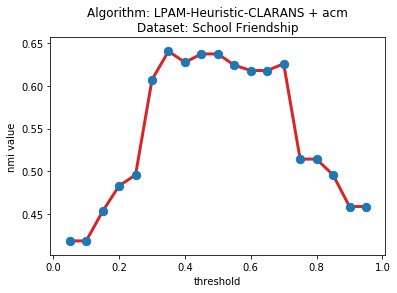

In [165]:
plot_all_params(algorithm = "LPAM-Heuristic-CLARANS + acm", dataset = "School Friendship", all_results = all_results)

## Clustering results for School Frienship Netwrok with the best parameters ##

![school-2_ACM_kmd_7_out](../final_pictures/school-2_ACM_kmd_7_out.png)

# Karate Club #

In [166]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/karate/karate.gml", 
              groundTruth = "../datasets/karate/truth_karate.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=False)

Output dir name: ../Results/lp_kmd_acm_karate
Output file name: ../Results/lp_kmd_acm_karate/pmp_karate_ACM_kmd_2.dat



Best ONMI: 0.91796 params: '-t 0.45'


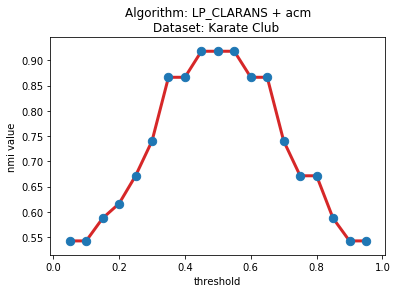

In [132]:
plot_all_params(algorithm = "LPAM-Heuristic_CLARANS + acm", dataset = "Karate Club ", all_results = all_results)

![karate_ACM_kmd_2_out](../final_pictures/karate_ACM_kmd_2_out.png)

# American Football League c = 12#

In [145]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=12, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/football/footballTSEinput.gml", 
              groundTruth = "../datasets/football/truth_footballTSEinput.dat", 
              params = params, 
              vertexNumerationShift=-1, 
              benchmarkFormat=False)

Output dir name: lp_kmd_acm_football
Output file name: lp_kmd_acm_football/pmp_footballTSEinput_ACM_kmd_12.dat



Best ONMI: 0.856281 params: '-t 0.55'


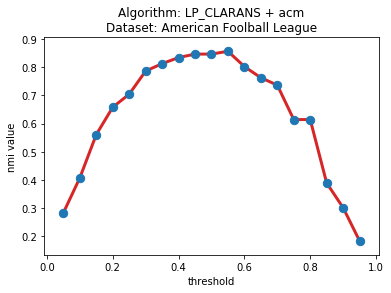

In [146]:
plot_all_params(algorithm = "LP_CLARANS + acm", dataset = "American Foolball League", all_results = all_results)

### Americal Football League  [onmi: 0.856281; thresould: 0.55]

![American Football Club](../final_pictures/screenshot_235054.png)

# Adj-noun#

In [152]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "kmd",
              distance = "acm",
              inputFile =  "../datasets/adjnoun/adjnoun.dat", 
              groundTruth = "../datasets/adjnoun/truth_adjnoun.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: lp_kmd_acm_adjnoun
Output file name: lp_kmd_acm_adjnoun/pmp_adjnoun_ACM_kmd_2.dat



Best ONMI: 0.00490969 params: '-t 0.1'


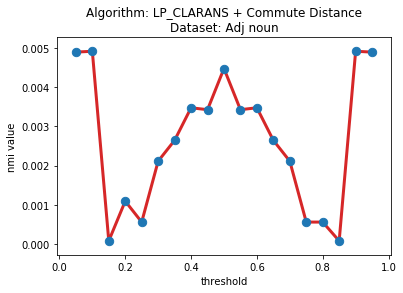

In [153]:
plot_all_params(algorithm = "LP_CLARANS + Commute Distance", dataset = "Adj noun", all_results = all_results)

### Adj-noun [ onmi: 0.00490969; thresould: 0.1 ] 

![adjnoun_ACM_kmd_2](../final_pictures/adjnoun_ACM_kmd_2_out.png)

# Politics Books #

In [147]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=2, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/polbooks/polbooks.dat",
              groundTruth = "../datasets/polbooks/truth_polbooks.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: lp_kmd_acm_polbooks
Output file name: lp_kmd_acm_polbooks/pmp_polbooks_ACM_kmd_2.dat



Best ONMI: 0.422712 params: '-t 0.55'


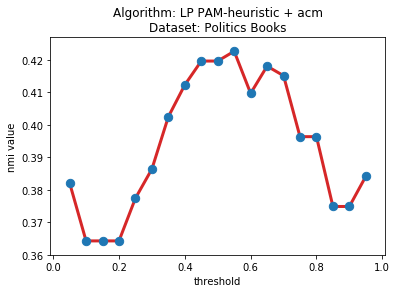

In [148]:
plot_all_params(algorithm = "LP PAM-heuristic + acm", dataset = "Politics Books", all_results = all_results)

![polbooks_ACM_kmd_2_out](../final_pictures/polbooks_ACM_kmd_2_out.png)

# Syntetic Datasets #

In [168]:
### bench_30 ###

In [169]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=3, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/bench_30/bench_30_network.dat",
              groundTruth = "../datasets/bench_30/bench_30_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_kmd_acm_bench_30
Output file name: ../Results/lp_kmd_acm_bench_30/pmp_bench_30_network_ACM_kmd_3.dat



Best ONMI: 0.931866 params: '-t 0.35000000000000003'


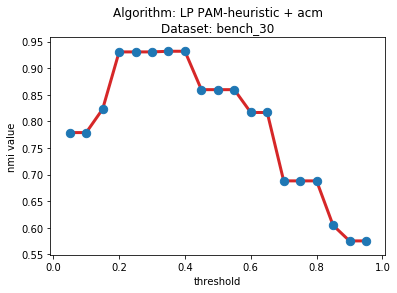

In [170]:
plot_all_params(algorithm = "LP PAM-heuristic + acm", dataset = "bench_30", all_results = all_results)

### bench_40 ###

In [172]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=3, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/bench_40/bench_40_network.dat",
              groundTruth = "../datasets/bench_40/bench_40_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_kmd_acm_bench_40
Output file name: ../Results/lp_kmd_acm_bench_40/pmp_bench_40_network_ACM_kmd_3.dat



Best ONMI: 0.273879 params: '-t 0.05'


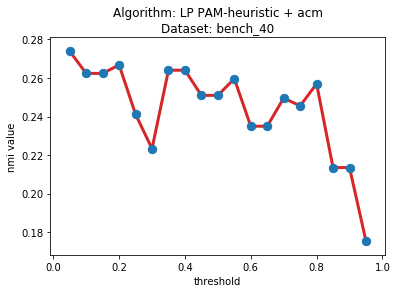

In [173]:
plot_all_params(algorithm = "LP PAM-heuristic + acm", dataset = "bench_40", all_results = all_results)

### bench_50 ###

In [176]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=4, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/bench_50/bench_50_network.dat",
              groundTruth = "../datasets/bench_50/bench_50_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_kmd_acm_bench_50
Output file name: ../Results/lp_kmd_acm_bench_50/pmp_bench_50_network_ACM_kmd_4.dat



Best ONMI: 0.845306 params: '-t 0.35000000000000003'


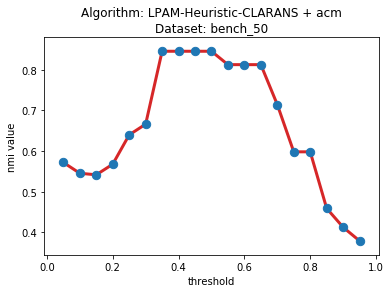

In [177]:
plot_all_params(algorithm = "LPAM-Heuristic-CLARANS + acm", dataset = "bench_50", all_results = all_results)

### bench_60 ###

In [178]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=6, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/bench_60/bench_60_network.dat",
              groundTruth = "../datasets/bench_60/bench_60_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_kmd_acm_bench_60
Output file name: ../Results/lp_kmd_acm_bench_60/pmp_bench_60_network_ACM_kmd_6.dat



Best ONMI: 0.586147 params: '-t 0.35000000000000003'


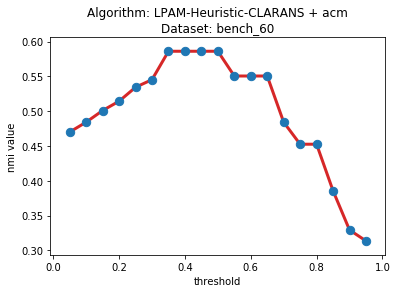

In [179]:
plot_all_params(algorithm = "LPAM-Heuristic-CLARANS + acm", dataset = "bench_60", all_results = all_results)

### bench_60_dense ###

In [181]:
params={}
params["-t"] = np.arange(0.05, 1.0, 0.05)
all_results = lp_experiment(clustersNumber=3, 
              algorithm = "kmd",
              distance = "acm",
              inputFile = "../datasets/bench_60_dense/bench_60_dense_network.dat",
              groundTruth = "../datasets/bench_60_dense/bench_60_dense_truth.dat", 
              params = params, 
              vertexNumerationShift=0, 
              benchmarkFormat=True)

Output dir name: ../Results/lp_kmd_acm_bench_60_dense
Output file name: ../Results/lp_kmd_acm_bench_60_dense/pmp_bench_60_dense_network_ACM_kmd_3.dat



Best ONMI: 0.283863 params: '-t 0.55'


In [ ]:
plot_all_params(algorithm = "LPAM-Heuristic-CLARANS + acm", dataset = "bench_60_dense", all_results = all_results)